In [87]:
import os
import pyspark

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as pysf 

import matplotlib.pyplot as plt

In [2]:
sc = SparkContext('local')
spark = SparkSession(sc)

In [3]:
gender_submission_file_path = "./titanic/gender_submission.csv"
train_file_path = "./titanic/train.csv"

In [48]:
genderDf = spark.read.options(header=True, inferSchema=True).csv(gender_submission_file_path)
trainDf = spark.read.options(header=True, inferSchema=True).csv(train_file_path)

In [49]:
genderDf.limit(5).show(vertical=True)

-RECORD 0----------
 PassengerId | 892 
 Survived    | 0   
-RECORD 1----------
 PassengerId | 893 
 Survived    | 1   
-RECORD 2----------
 PassengerId | 894 
 Survived    | 0   
-RECORD 3----------
 PassengerId | 895 
 Survived    | 0   
-RECORD 4----------
 PassengerId | 896 
 Survived    | 1   



In [50]:
trainDf.limit(5).show(vertical=True)

-RECORD 0---------------------------
 PassengerId | 1                    
 Survived    | 0                    
 Pclass      | 3                    
 Name        | Braund, Mr. Owen ... 
 Sex         | male                 
 Age         | 22.0                 
 SibSp       | 1                    
 Parch       | 0                    
 Ticket      | A/5 21171            
 Fare        | 7.25                 
 Cabin       | null                 
 Embarked    | S                    
-RECORD 1---------------------------
 PassengerId | 2                    
 Survived    | 1                    
 Pclass      | 1                    
 Name        | Cumings, Mrs. Joh... 
 Sex         | female               
 Age         | 38.0                 
 SibSp       | 1                    
 Parch       | 0                    
 Ticket      | PC 17599             
 Fare        | 71.2833              
 Cabin       | C85                  
 Embarked    | C                    
-RECORD 2---------------------------
 

In [51]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [52]:
trainDf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [53]:
trainDf.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in trainDf.columns]
).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [54]:
trainDf = trainDf.fillna(value=-1.0, subset=["Age"])\
    .fillna(value="NOTFOUND", subset=["Embarked"])\
    .fillna(value="NOTFOUND", subset=["Cabin"])


In [55]:
trainDf.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in trainDf.columns]
).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [56]:
def parseCabinSection(cabin):
    return cabin[0]

In [57]:
parseCabinSectionUDF = F.udf(lambda x:parseCabinSection(x), T.StringType())   


In [58]:
trainDf = trainDf.withColumn("CabinSection", parseCabinSectionUDF(F.col("Cabin")))

In [67]:
# trainDf.groupBy(F.col("CabinSection"),F.col("Sex"), F.col("Survived")).mean().sort(F.col("Survived")).show()
checkDf = trainDf.groupBy(F.col("CabinSection")).agg(
    F.count("CabinSection").alias("CabintTot")
).withColumnRenamed("CabinSection", "CabinSection1")
checkDf.show()
trainDf.groupBy(F.col("CabinSection"),F.col("Sex"), F.col("Survived")).agg(
    F.count("CabinSection").alias("CabintSum"),
).join(checkDf, trainDf.CabinSection == checkDf.CabinSection1, 'left_outer').drop("CabinSection1").sort(F.col("CabinSection")).show()


+-------------+---------+
|CabinSection1|CabintTot|
+-------------+---------+
|            F|       13|
|            E|       32|
|            T|        1|
|            B|       47|
|            D|       33|
|            C|       59|
|            A|       15|
|            N|      687|
|            G|        4|
+-------------+---------+

+------------+------+--------+---------+---------+
|CabinSection|   Sex|Survived|CabintSum|CabintTot|
+------------+------+--------+---------+---------+
|           A|  male|       1|        6|       15|
|           A|  male|       0|        8|       15|
|           A|female|       1|        1|       15|
|           B|female|       1|       27|       47|
|           B|  male|       0|       12|       47|
|           B|  male|       1|        8|       47|
|           C|female|       0|        3|       59|
|           C|female|       1|       24|       59|
|           C|  male|       0|       21|       59|
|           C|  male|       1|       11|       59

In [78]:
calculateSurvialByCabinSectionUDF = F.udf(lambda x, y : (x/y) * 100, T.DoubleType())

In [129]:
cabindSectionDf = trainDf\
    .groupBy(F.col("CabinSection"),F.col("Sex"), F.col("Survived"))\
    .agg(F.count("CabinSection").alias("CabintSum"))\
    .join(checkDf, trainDf.CabinSection == checkDf.CabinSection1, 'left_outer')\
    .drop("CabinSection1")\
    .withColumn("ProbSurvival", calculateSurvialByCabinSectionUDF(F.col("CabintSum"), F.col("CabintTot")))

cabindSectionDf.sort(F.col("Survived").desc(), F.col("ProbSurvival").desc())\
    .show(100)

+------------+------+--------+---------+---------+------------------+
|CabinSection|   Sex|Survived|CabintSum|CabintTot|      ProbSurvival|
+------------+------+--------+---------+---------+------------------+
|           B|female|       1|       27|       47|57.446808510638306|
|           D|female|       1|       18|       33| 54.54545454545454|
|           G|female|       1|        2|        4|              50.0|
|           E|female|       1|       14|       32|             43.75|
|           C|female|       1|       24|       59| 40.67796610169492|
|           A|  male|       1|        6|       15|              40.0|
|           F|female|       1|        5|       13| 38.46153846153847|
|           E|  male|       1|       10|       32|             31.25|
|           F|  male|       1|        3|       13|23.076923076923077|
|           D|  male|       1|        7|       33| 21.21212121212121|
|           N|female|       1|      142|      687| 20.66957787481805|
|           C|  male

In [130]:
femaleCabinSurvialDf = cabindSectionDf.filter((F.col("Sex") == "female")  & (F.col("Survived") == 1)).select("CabinSection", "ProbSurvival")
maleCabinSurvivalDf = cabindSectionDf.filter((F.col("Sex") == "male")  & (F.col("Survived") == 1)).select(F.col("CabinSection").alias("MaleCabinSection"), F.col("ProbSurvival").alias("MaleProbSurvival"))
plotDF = femaleCabinSurvialDf.join(maleCabinSurvivalDf, femaleCabinSurvialDf.CabinSection == maleCabinSurvivalDf.MaleCabinSection, 'left_outer').drop("MaleCabinSection").fillna(0)

In [131]:
# data visualization efforts
from collections import defaultdict
plotDetails = plotDF.collect()
cabinSectionDetails = defaultdict(list)
for row in plotDetails:
    cabinSectionDetails["cabin"].append(row.CabinSection)
    cabinSectionDetails["female"].append(row.ProbSurvival)
    cabinSectionDetails["male"].append(row.MaleProbSurvival)
    
print(cabinSectionDetails)

defaultdict(<class 'list'>, {'cabin': ['A', 'G', 'B', 'F', 'C', 'N', 'E', 'D'], 'female': [6.666666666666667, 50.0, 57.446808510638306, 38.46153846153847, 40.67796610169492, 20.66957787481805, 43.75, 54.54545454545454], 'male': [40.0, 0.0, 17.02127659574468, 23.076923076923077, 18.64406779661017, 9.315866084425037, 31.25, 21.21212121212121]})


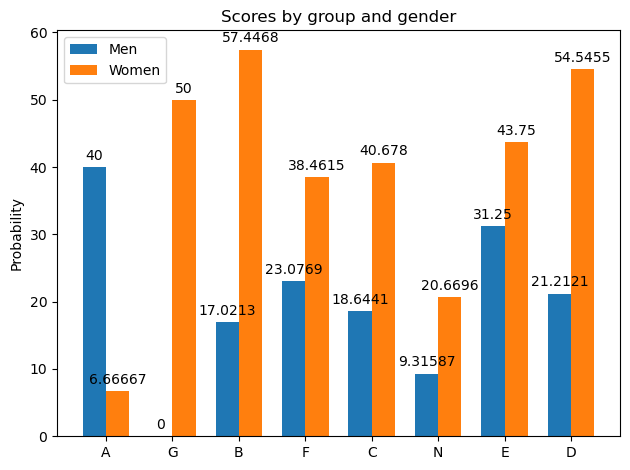

In [132]:
import matplotlib.pyplot as plt

# labels = ['G1', 'G2', 'G3', 'G4', 'G5']
labels = cabinSectionDetails.get('cabin')
men_means = cabinSectionDetails.get('male')
women_means = cabinSectionDetails.get('female')

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [180]:
trainDf.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = false)
 |-- Embarked: string (nullable = false)
 |-- CabinSection: string (nullable = true)



In [21]:
trainDf.summary().show(vertical=True)

-RECORD 0----------------------------
 summary      | count                
 PassengerId  | 891                  
 Survived     | 891                  
 Pclass       | 891                  
 Name         | 891                  
 Sex          | 891                  
 Age          | 891                  
 SibSp        | 891                  
 Parch        | 891                  
 Ticket       | 891                  
 Fare         | 891                  
 Cabin        | 891                  
 Embarked     | 891                  
 CabinSection | 891                  
-RECORD 1----------------------------
 summary      | mean                 
 PassengerId  | 446.0                
 Survived     | 0.3838383838383838   
 Pclass       | 2.308641975308642    
 Name         | null                 
 Sex          | null                 
 Age          | 23.600639730639728   
 SibSp        | 0.5230078563411896   
 Parch        | 0.38159371492704824  
 Ticket       | 260318.54916792738   
 Fare       

In [111]:
trainDf\
    .groupBy(F.col("Pclass"), F.col("Sex"), F.col("Survived"))\
    .count()\
    .sort(F.col("Pclass"), F.col("Sex")).show()

+------+------+--------+-----+
|Pclass|   Sex|Survived|count|
+------+------+--------+-----+
|     1|female|       1|   91|
|     1|female|       0|    3|
|     1|  male|       1|   45|
|     1|  male|       0|   77|
|     2|female|       1|   70|
|     2|female|       0|    6|
|     2|  male|       1|   17|
|     2|  male|       0|   91|
|     3|female|       1|   72|
|     3|female|       0|   72|
|     3|  male|       1|   47|
|     3|  male|       0|  300|
+------+------+--------+-----+



In [59]:
outputDf.limit(1500).show(1500)

+-----------+--------+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
+-----------+--------+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

